<a href="https://colab.research.google.com/github/Asher-Topaz/AIGC5500_advanced_deep_learning/blob/main/N01666733_lab4_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
BATCH_SIZE = 16



In [ ]:
def train_model(
    model,
    device,
    epochs,
    batch_size,
    trainset,
    testset,
    optimizer,
    loss_function,
    metric,
):

    train_losses = []
    test_losses = []
    epoch_list = []


In [ ]:
def train_model(
    model,
    device,
    epochs,
    batch_size,
    trainset,
    testset,
    optimizer,
    loss_function,
    metric,
):
    train_losses = []
    test_losses = []
    epoch_list = []

    # Transfer model to GPU.
    model.to(device)

    # Create dataloaders.
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    acc = False
    mae = False
    if metric == "acc":
        acc = True
    elif metric == "mae":
        mae = True
    else:
        print("Error: unsupported metric")
        return

    for i in range(epochs):
        model.train()  # Set model in training mode.
        train_loss = 0.0
        if acc:
            train_correct = 0
        if mae:
            train_absolute_error = 0.0
        train_batches = 0
        for inputs, targets in trainloader:
            # Move data to GPU.
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward pass.
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # Accumulate metrics.
            if acc:
                _, indices = torch.max(outputs.data, 1)
                train_correct += (indices == targets).sum().item()
            if mae:
                train_absolute_error += (targets - outputs.data).abs().sum().item()
            train_batches += 1
            train_loss += loss.item()

            # Backward pass and update.
            loss.backward()
            optimizer.step()

        train_loss = train_loss / train_batches
        train_losses.append(train_loss)
        if acc:
            train_acc = train_correct / (train_batches * batch_size)
        if mae:
            train_mae = train_absolute_error / (train_batches * batch_size)

        # Evaluate the model on the test dataset.
        model.eval()  # Set model in inference mode.
        test_loss = 0.0
        if acc:
            test_correct = 0
        if mae:
            test_absolute_error = 0.0
        test_batches = 0
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            if acc:
                _, indices = torch.max(outputs.data, 1)
                test_correct += (indices == targets).sum().item()
            if mae:
                test_absolute_error += (targets - outputs.data).abs().sum().item()
            test_batches += 1
            test_loss += loss.item()
        test_loss = test_loss / test_batches
        test_losses.append(test_loss)
        if acc:
            test_acc = test_correct / (test_batches * batch_size)
            print(
                f"Epoch {i+1}/{epochs} loss: {train_loss:.4f} - acc: {train_acc:0.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:0.4f}"
            )
            return_value = [train_acc, test_acc]
        if mae:
            test_mae = test_absolute_error / (test_batches * batch_size)
            print(
                f"Epoch {i+1}/{epochs} loss: {train_loss:.4f} - mae: {train_mae:0.4f} - val_loss: {test_loss:.4f} - val_mae: {test_mae:0.4f}"
            )
            return_value = [train_mae, test_mae]

        epoch_list.append(i)
    plt.plot(epoch_list, train_losses)
    plt.plot(epoch_list, test_losses)
    plt.title("learning curve")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper right")
    plt.show()
    return return_value


In [ ]:
# Read and standardize the data.
california_housing = fetch_california_housing()
data = california_housing.get("data")
target = california_housing.get("target")

raw_x_train, raw_x_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=0
)

# Convert to same precision as model.
raw_x_train = raw_x_train.astype(np.float32)
raw_x_test = raw_x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

x_mean = np.mean(raw_x_train, axis=0)
x_stddev = np.std(raw_x_train, axis=0)
x_train = (raw_x_train - x_mean) / x_stddev
x_test = (raw_x_test - x_mean) / x_stddev

# Create Dataset objects.
trainset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
testset = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))


In [ ]:
# Function to create and initialize the model
def create_model():
    model = nn.Sequential(
        nn.Linear(8, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 1)
    )
    # Initialize weights.
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0.0)
    return model


Training model with lambda (weight decay) = 0.001
Epoch 1/50 loss: 0.6135 - mae: 0.5304 - val_loss: 0.4482 - val_mae: 0.4376
Epoch 2/50 loss: 0.3766 - mae: 0.4343 - val_loss: 0.4079 - val_mae: 0.4446
Epoch 3/50 loss: 0.3546 - mae: 0.4189 - val_loss: 0.3537 - val_mae: 0.4135
Epoch 4/50 loss: 0.3391 - mae: 0.4077 - val_loss: 0.7240 - val_mae: 0.4122
Epoch 5/50 loss: 0.3821 - mae: 0.4056 - val_loss: 0.3269 - val_mae: 0.3999
Epoch 6/50 loss: 0.3174 - mae: 0.3930 - val_loss: 0.3427 - val_mae: 0.4091
Epoch 7/50 loss: 0.3198 - mae: 0.3904 - val_loss: 0.5595 - val_mae: 0.4118
Epoch 8/50 loss: 0.3234 - mae: 0.3886 - val_loss: 0.3586 - val_mae: 0.3870
Epoch 9/50 loss: 0.3116 - mae: 0.3834 - val_loss: 0.4403 - val_mae: 0.4056
Epoch 10/50 loss: 0.3104 - mae: 0.3821 - val_loss: 0.3889 - val_mae: 0.4007
Epoch 11/50 loss: 0.3029 - mae: 0.3783 - val_loss: 0.3077 - val_mae: 0.3783
Epoch 12/50 loss: 0.2948 - mae: 0.3741 - val_loss: 0.3204 - val_mae: 0.4001
Epoch 13/50 loss: 0.3018 - mae: 0.3769 - val_lo

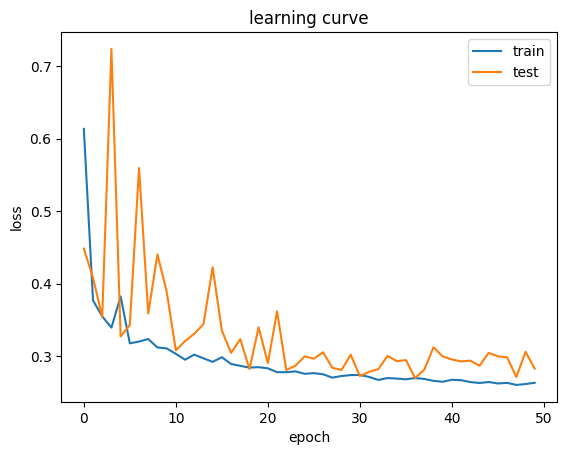

Lambda: 0.001, MSE: 0.28243258595466614
Training model with lambda (weight decay) = 0.01
Epoch 1/50 loss: 0.6335 - mae: 0.5437 - val_loss: 0.4019 - val_mae: 0.4444
Epoch 2/50 loss: 0.4059 - mae: 0.4499 - val_loss: 0.3916 - val_mae: 0.4611
Epoch 3/50 loss: 0.3836 - mae: 0.4369 - val_loss: 0.4183 - val_mae: 0.4244
Epoch 4/50 loss: 0.3827 - mae: 0.4339 - val_loss: 0.3925 - val_mae: 0.4213
Epoch 5/50 loss: 0.3671 - mae: 0.4270 - val_loss: 0.3803 - val_mae: 0.4195
Epoch 6/50 loss: 0.3583 - mae: 0.4215 - val_loss: 0.3725 - val_mae: 0.4193
Epoch 7/50 loss: 0.3543 - mae: 0.4192 - val_loss: 0.3538 - val_mae: 0.4391
Epoch 8/50 loss: 0.3505 - mae: 0.4170 - val_loss: 0.3470 - val_mae: 0.4146
Epoch 9/50 loss: 0.3472 - mae: 0.4151 - val_loss: 0.4093 - val_mae: 0.4208
Epoch 10/50 loss: 0.3519 - mae: 0.4141 - val_loss: 0.3527 - val_mae: 0.4040
Epoch 11/50 loss: 0.3458 - mae: 0.4138 - val_loss: 0.3577 - val_mae: 0.4385
Epoch 12/50 loss: 0.3420 - mae: 0.4115 - val_loss: 0.3571 - val_mae: 0.4304
Epoch 13

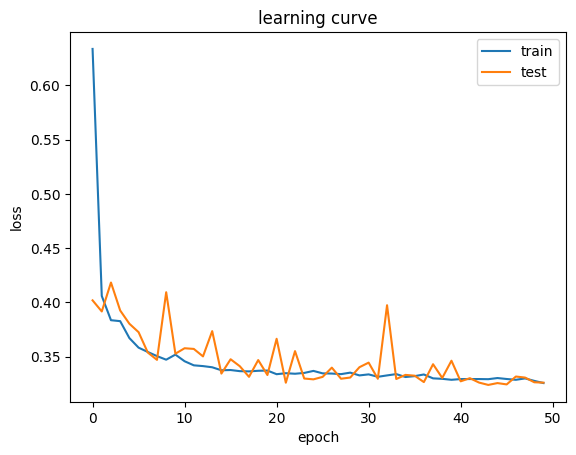

Lambda: 0.01, MSE: 0.32604750990867615
Training model with lambda (weight decay) = 0.1
Epoch 1/50 loss: 0.6901 - mae: 0.5730 - val_loss: 0.4967 - val_mae: 0.4973
Epoch 2/50 loss: 0.4781 - mae: 0.4935 - val_loss: 0.4910 - val_mae: 0.4888
Epoch 3/50 loss: 0.4768 - mae: 0.4935 - val_loss: 0.4713 - val_mae: 0.4904
Epoch 4/50 loss: 0.4753 - mae: 0.4940 - val_loss: 0.4650 - val_mae: 0.4890
Epoch 5/50 loss: 0.4765 - mae: 0.4939 - val_loss: 0.4868 - val_mae: 0.4954
Epoch 6/50 loss: 0.4801 - mae: 0.4974 - val_loss: 0.4812 - val_mae: 0.4961
Epoch 7/50 loss: 0.4781 - mae: 0.4967 - val_loss: 0.4790 - val_mae: 0.4825
Epoch 8/50 loss: 0.4786 - mae: 0.4965 - val_loss: 0.4797 - val_mae: 0.4869
Epoch 9/50 loss: 0.4769 - mae: 0.4953 - val_loss: 0.4775 - val_mae: 0.4863
Epoch 10/50 loss: 0.4816 - mae: 0.4967 - val_loss: 0.4961 - val_mae: 0.5420
Epoch 11/50 loss: 0.4760 - mae: 0.4956 - val_loss: 0.4762 - val_mae: 0.5129
Epoch 12/50 loss: 0.4760 - mae: 0.4953 - val_loss: 0.4706 - val_mae: 0.4930
Epoch 13/5

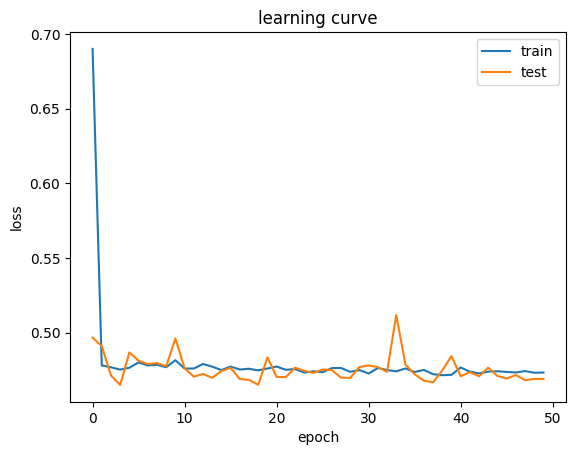

Lambda: 0.1, MSE: 0.4689771831035614
Training model with lambda (weight decay) = 1.0
Epoch 1/50 loss: 0.9807 - mae: 0.6939 - val_loss: 0.8278 - val_mae: 0.6461
Epoch 2/50 loss: 0.8495 - mae: 0.6586 - val_loss: 0.8822 - val_mae: 0.6749
Epoch 3/50 loss: 0.8707 - mae: 0.6696 - val_loss: 0.8709 - val_mae: 0.6694
Epoch 4/50 loss: 0.8754 - mae: 0.6719 - val_loss: 0.8517 - val_mae: 0.6700
Epoch 5/50 loss: 0.8781 - mae: 0.6731 - val_loss: 0.7822 - val_mae: 0.6403
Epoch 6/50 loss: 0.8722 - mae: 0.6712 - val_loss: 0.8247 - val_mae: 0.6537
Epoch 7/50 loss: 0.8766 - mae: 0.6724 - val_loss: 0.8072 - val_mae: 0.6511
Epoch 8/50 loss: 0.8842 - mae: 0.6736 - val_loss: 0.8740 - val_mae: 0.6731
Epoch 9/50 loss: 0.8730 - mae: 0.6712 - val_loss: 0.8384 - val_mae: 0.6632
Epoch 10/50 loss: 0.8718 - mae: 0.6700 - val_loss: 0.9698 - val_mae: 0.7035
Epoch 11/50 loss: 0.8765 - mae: 0.6724 - val_loss: 0.8945 - val_mae: 0.6752
Epoch 12/50 loss: 0.8770 - mae: 0.6721 - val_loss: 0.8364 - val_mae: 0.6560
Epoch 13/50 

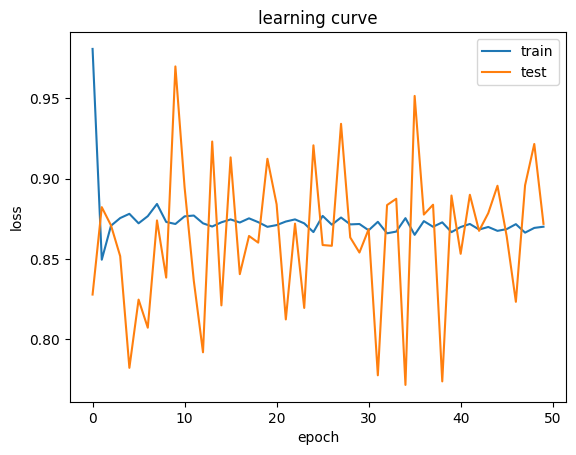

Lambda: 1.0, MSE: 0.8718432188034058

Best lambda: 0.001, with MSE: 0.28243258595466614


In [ ]:
# List of lambda (weight decay) values to test
lambda_values = [0.001, 0.01, 0.1, 1.0]
best_lambda = None
best_mse = float('inf')

for l2_reg in lambda_values:
    print(f"Training model with lambda (weight decay) = {l2_reg}")

    # Create model
    model = create_model()
    model.to(device)

    # Loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=l2_reg)
    loss_function = nn.MSELoss()

    # Train model
    train_model(
        model,
        device,
        EPOCHS,
        BATCH_SIZE,
        trainset,
        testset,
        optimizer,
        loss_function,
        "mae",
    )

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        inputs = torch.from_numpy(x_test).to(device)
        outputs = model(inputs)
        mse = loss_function(outputs, torch.from_numpy(y_test).to(device)).item()

    print(f"Lambda: {l2_reg}, MSE: {mse}")

    # Update best lambda and mse
    if mse < best_mse:
        best_mse = mse
        best_lambda = l2_reg

print(f"\nBest lambda: {best_lambda}, with MSE: {best_mse}")



Training final model with best lambda = 0.001
Epoch 1/50 loss: 0.6212 - mae: 0.5349 - val_loss: 0.4114 - val_mae: 0.4442
Epoch 2/50 loss: 0.3721 - mae: 0.4299 - val_loss: 0.4514 - val_mae: 0.4199
Epoch 3/50 loss: 0.3494 - mae: 0.4138 - val_loss: 0.4283 - val_mae: 0.4150
Epoch 4/50 loss: 0.3455 - mae: 0.4029 - val_loss: 0.5425 - val_mae: 0.4007
Epoch 5/50 loss: 0.3182 - mae: 0.3919 - val_loss: 0.3091 - val_mae: 0.3918
Epoch 6/50 loss: 0.3120 - mae: 0.3870 - val_loss: 0.3324 - val_mae: 0.3810
Epoch 7/50 loss: 0.3092 - mae: 0.3820 - val_loss: 0.3523 - val_mae: 0.3817
Epoch 8/50 loss: 0.3058 - mae: 0.3790 - val_loss: 0.3136 - val_mae: 0.3779
Epoch 9/50 loss: 0.3005 - mae: 0.3762 - val_loss: 0.3402 - val_mae: 0.3927
Epoch 10/50 loss: 0.2924 - mae: 0.3724 - val_loss: 0.2939 - val_mae: 0.3706
Epoch 11/50 loss: 0.2910 - mae: 0.3716 - val_loss: 0.3206 - val_mae: 0.3735
Epoch 12/50 loss: 0.2887 - mae: 0.3668 - val_loss: 0.3151 - val_mae: 0.3664
Epoch 13/50 loss: 0.2887 - mae: 0.3676 - val_loss:

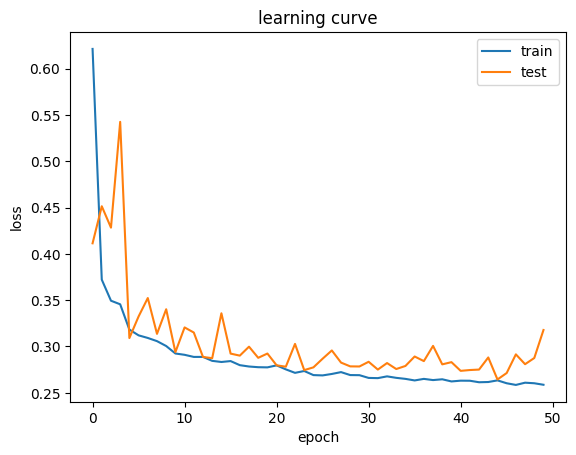

Prediction: 1.44 , true value: 1.37
Prediction: 2.60 , true value: 2.41
Prediction: 1.53 , true value: 2.01
Prediction: 0.76 , true value: 0.73

>>> END <<<


In [ ]:
# Train the final model with the optimal lambda
print(f"\nTraining final model with best lambda = {best_lambda}")
final_model = create_model()
final_model.to(device)
optimizer = torch.optim.Adam(final_model.parameters(), weight_decay=best_lambda)
train_model(
    final_model,
    device,
    EPOCHS,
    BATCH_SIZE,
    trainset,
    testset,
    optimizer,
    loss_function,
    "mae",
)

# Evaluate the final model on the test set
final_model.eval()
with torch.no_grad():
    inputs = torch.from_numpy(x_test).to(device)
    outputs = final_model(inputs)
    for i in range(0, 4):
        print(
            "Prediction: %4.2f" % outputs.data[i].item(),
            ", true value: %4.2f" % y_test[i].item(),
        )

print("\n>>> END <<<")


#Observation

The role of lambda parameters is to control regularization magnitude which helps to prevent overfitting and enhance model performance.

Lambda parameters control the balance between bias and variance.
A high lambda value means higher amount of regularization with a higher bias and lower variance.

A lower lambda value on the other hand decreases regularization therefore making the model more complex with loweer bias but higher variance.

In order to achive best performance it is important to find the optimal lambda value. I did this using grid search on lambda values, 0.001, 0.01, 0.1 and 1.0 respectively.

The lowest lambda value 0.001 had an MSE score of 0.284. This was the lowest MSE score. Which means that for these data set and neural network model, low lambda values no more than 0.001 with minimal regularization is sufficient.

The lambda values matter because if its higher than necessary then it would lead to loss in perfromance as the grid search on the lambda values has shown.

I believe for these data set and model regularization isnt necessary for high performance however if one where to use regularization then lambda values <= 0.001 is sufficient.

